# Resistance Estimation Using Ohm's Law

## Introduction
This notebook demonstrates how to estimate the resistance of an electrical component using Ohm's Law and the method of least squares.

We aim to determine the resistance ($R$) of a resistor by fitting a line $V = RI$ based on the following data:

| Current (A) | Voltage (V) |
|-------------|-------------|
| 0.2         | 1.23        |
| 0.3         | 1.38        |
| 0.4         | 2.06        |
| 0.5         | 2.47        |
| 0.6         | 3.17        |

### Objectives

- Use least-squares to determine the resistance $R$.
- Visualize the results with a plot.

---

## Recursive Least Squares
Given your experience with batch least squares (where all measurements are processed at once), you now decide to convert your batch solution to a recursive one for added flexibility. Recall that you have the following data:

| Current (A) | Voltage (V) |
|-------------|-------------|
| 0.2         | 1.23        |
| 0.3         | 1.38        |
| 0.4         | 2.06        |
| 0.5         | 2.47        |
| 0.6         | 3.17        |

This time, you intend to fit a linear model that includes an offset term, $V = RI + b$. If Ohm's law ($V = RI$) holds, you expect this offset to be very near to zero.

To use the recursive least squares formulation, you must have a prior estimate of the resistance and its associated uncertainty (otherwise, you won't know how to weigh the information you receive from a new measurement). You choose to set the initial parameters under the assumption that your prior estimate of the resistance, $R = 4$, is not very good. Also, since you are fairly sure that Ohm's law ($V = RI$) does, in fact, hold, you feel that it is safe to assume with high confidence that the offset term $b$ is close to zero. After some thought, you choose to initialize the recursive estimator as follows:

$$\hat{R} \sim \mathcal{N}(4, 9.0),~~\hat{b} \sim \mathcal{N}(0, 0.2)$$

Your initial guess is that $\hat{R}$ follows a Gaussian or normal distribution (recall that you do not know the exact value of $R$, so it must be considered as a random variable) with a mean of $4~\Omega$ and a standard deviation of $3~ \Omega$ (i.e., a variance of $9~\Omega^{2}$). Similarly, your initial guess is that $\hat{b}$ should also follow a normal distribution with a mean of $0~V$ and a variance of $0.2~V^{2}$.

With the data again in hand, your goals are to:
1. Fit a line to the data that includes an offset term (i.e., determine the parameters $R$ and $b$ for $y = Rx + b$) by using the method of recursive least squares.
2. Reflect on the differences between the batch and recursive least squares solutions.

You may assume that the current values are known exactly, and that the voltage measurements are corrupted by additive, independent, and identically distributed zero-mean Gaussian noise with a standard deviation of $0.15~V$ (i.e., a variance of $0.0225 ~ V^2$). You may also assume that your initial estimates for $\hat{R}$ and $\hat{b}$ are uncorrelated (i.e., the off-diagonal elements of the $2 \times 2$ covariance matrix are zero).

---

## Getting Started
The first step is to import the necessary Python modules and load the current values and voltage measurements into NumPy arrays:


In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [2]:
I = np.array([[0.2, 0.3, 0.4, 0.5, 0.6]]).T
V = np.array([[1.23, 1.38, 2.06, 2.47, 3.17]]).T

In [3]:
print(I.shape)
print(V.shape)

(5, 1)
(5, 1)


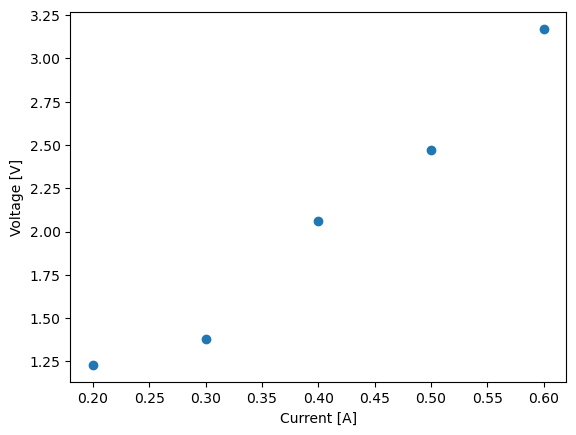

In [4]:
plt.scatter(I, V)
plt.xlabel("Current [A]")
plt.ylabel("Voltage [V]")
plt.show()

In [5]:
H= I.copy()
y= V.copy()
R = np.linalg.inv(H.T@H)@H.T@y
print('The resistance is estimated as : %f' %R[0,0])

The resistance is estimated as : 5.134444


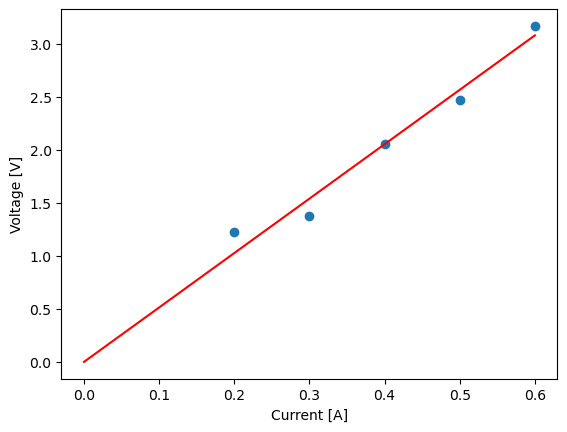

In [6]:
I_data = np.arange(0,0.7,0.1).reshape(-1,1)
V_data= R*I_data
plt.scatter(I,V)
plt.plot(I_data,V_data,'r')
plt.xlabel('Current [A]')
plt.ylabel('Voltage [V]')
plt.show()

In [7]:
H = np.ones((5,2))
H[:,0]=I.T
x_ls = np.linalg.inv(H.T@H)@H.T@V
print('The slope and offset parameters using Least sqaure: R = %f and b = %f ' %(x_ls[0,0],x_ls[1,0]))


The slope and offset parameters using Least sqaure: R = 4.970000 and b = 0.074000 


In [8]:
R = x_ls[0,0]
b = x_ls[1,0]
I_line = np.arange(0, 0.8, 0.1).reshape(-1,1)
V_line = R*I_line + b

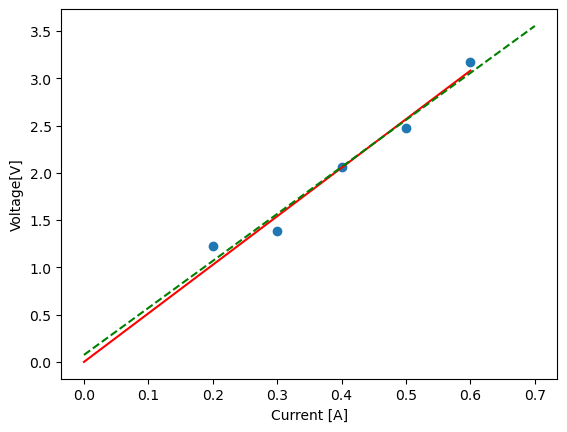

In [9]:
plt.scatter(I,V)
plt.plot(I_data,V_data,'r')
plt.plot(I_line,V_line, '--g')
plt.xlabel('Current [A]')
plt.ylabel('Voltage[V]')
plt.show()


In [12]:
x_k = np.array([[4.0 , 0]]).reshape(2,1)

P_k = np.array([[9.0,0],[0,0.2]])
R_k = np.array([[0.0225]])

num_meas = I.shape[0]
x_hist = np.zeros((num_meas + 1,2))
P_hist =  np.zeros((num_meas + 1, 2, 2))

x_hist[0]  = x_k.reshape(1,2)
P_hist[0] = P_k


In [17]:
for k in range(num_meas):
    H_k = np.concatenate([I[k],[1]]).reshape(-1,2)
    K_k = P_k @ H_k.T @ np.linalg.inv(H_k @ P_k @ H_k.T + R_k)
    x_k = x_k + K_k@(V[k] - H_k @ x_k)
    P_k = P_k - K_k@H_k@P_k
    x_hist[k+1] = x_k.reshape(1,2)
    P_hist[k+1] = P_k
R,b= x_k[0,0],x_k[1,0]
print('The slope and offest using Recursive Least Sqaure: R= %f and b= %f' %(R,b))



The slope and offest using Recursive Least Sqaure: R= 4.888273 and b= 0.114986


In [18]:
I_RLS = np.arange(0,0.7,0.1)
V_RLS = R*I_RLS+b

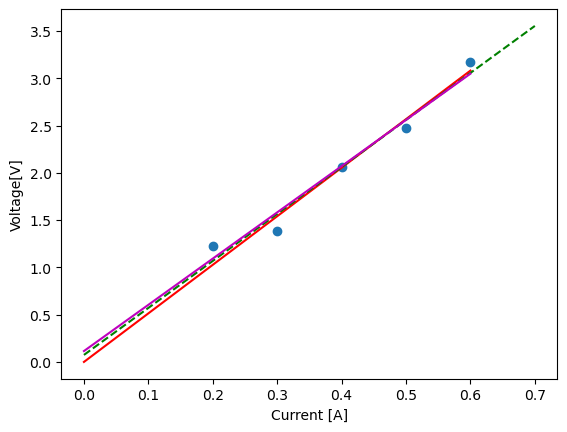

In [20]:
plt.scatter(I,V)
plt.plot(I_data,V_data,'r')
plt.plot(I_line,V_line, '--g')
plt.plot(I_RLS,V_RLS,'m')
plt.xlabel('Current [A]')
plt.ylabel('Voltage[V]')
plt.show()
